# Tratamento de dados output BoltzTraP

## Dependencia da figura de mérito com o Potencial Químico, Tempo de relaxação eletrônico e Temperatura *

Existem duas linhas de trabalho distintas aqui:

A parte comum é o programa "1_resume_condtens_kappa_corrigido.py", o que esse programa faz é ler o output
do BoltzTraP e filtrar somente o range de potencial químico de interesse, bem como as colunas de interesse.

Nesse notebook vamos focar na segunda linha.
	
Lembre: O boltztrap calcula os coeficientes de transporte com uma dependencia em 3 parâmetros, 
	são eles: potencial quimico, temperatura e tempos de relaxação.
	O que eu faço nessa linha de trabalho é fixar a temperatura e analisar como os coeficientes de transporte se comportam como uma função do potencial quimico e tempos de relaxação, supondo, é claro, que esses são independentes entre si.
    

* Temperatura e tempos de relaxação obviamente são relacionados. Essa suposição é feita pois temos motivos pra acreditar que, nos dados experimentais disponíveis, a maior parte dos baixíssimos tempos de relaxação obtidos no método semi-empírico seja justificada por impurezas incorporadas na amostra durante o crescimento dos cristais, e, no caso em que essas possam ser evitadas com métodos mais modernos, esses tempos podem ser aumentados para uma mesma temperatura.

In [1]:
'''
Primeiro programa no tratamento de dados!
Esse programa pega o arquivo as2se3.condtens que saiu do boltztrap, filtra os dados de interesse 
e faz a correção da condutividade térmica eletronica (Vide equação 6.6 da dissertação).
Os dados de interesse no arquivo .condtens são: ("$" representa a coluna).

  $1     $2   $3   $4        $8      $12    $13  $17  $21    $22       $26        $30   
Ef(Ry)  T(K)  N  sigma_a  sigma_b  sigma_c  S_a  S_b  S_c  kappa_0a  kappa_0b  kappa_0c

esse programa filtra o range de potquim de interesse convertendo para eV, e escreve os dados da seguinte forma:

  $1     $2      $3       $4      $5     $6   $7   $8      $9       $10       $11       $12         $13      $14      $15     $16     $17      $18       $19      $20
Ef(eV)  T(K)  sigma_a  sigma_b  sigma_c  S_a  S_b  S_c  kappa_ea  kappa_eb  kappa_ec  kappa_0a  kappa_0b  kappa_0c  Corr_a  Corr_b  Corr_c  kappa_la  kappa_lb  kappa_lc

onde Corr_i é a diferença entre kappa_0i e kappa_ei

'''
import numpy as np
from tqdm import tqdm


# LEITURA - dados calculados com o BoltzTraP
CAMINHO = "./../as2se3.condtens"
Condtens = open(CAMINHO, 'r')

# ESCRITA - Arquivo onde ficarão os dados de interesse
ESCRITA = open('condtens_resumido_kappa_corrigido', 'w')

#Parâmetros de controle:
potquim_min_eV=-2
potquim_max_eV=3
u = u_min = round((potquim_min_eV / 13.605698066 - 0.003433), 5)
u_max = round((potquim_max_eV / 13.605698066 - 0.003433), 5)
du = 0.0001
#
#Programa principal
print(f'Porcentagem do arquivo já processada: \n')
with tqdm(total = 100) as barra_progresso:
    while u <= u_max:
        for j, linha_boltz in enumerate(Condtens):
            linha_boltz = linha_boltz.strip().split()
            if j > 0: #Só para pular o cabeçalho
                boltz = [float(i) for i in linha_boltz]
                
                # Parametros que vão ajudar na visualização do avançar do programa
                if j == 1 and u == u_min:
                    feito = np.linspace(boltz[0], u_max, 101)
                    atual = 0
                    
                #controle de quanto já foi executado
                if boltz[0] == round(float(feito[atual]), 5):
                    barra_progresso.update(1)
                    atual += 1
                    
                #Filtragem
                if u == boltz[0] and boltz[1] >= 260:
                    #variaveis
                    mu = round(((u + 0.003433) * 13.605698066), 5)
                    T = int(boltz[1])
                    sigma_a = boltz[3]
                    sigma_b = boltz[7]
                    sigma_c = boltz[11]
                    seebeck_a = boltz[12]
                    seebeck_b = boltz[16]
                    seebeck_c = boltz[20]
                    kappa_0_a = boltz[21]
                    kappa_0_b = boltz[25]
                    kappa_0_c = boltz[29]
                    correction_a = T * sigma_a * seebeck_a * seebeck_a
                    correction_b = T * sigma_b * seebeck_b * seebeck_b
                    correction_c = T * sigma_c * seebeck_c * seebeck_c
                    kappa_e_a = (boltz[21] - T * sigma_a * seebeck_a * seebeck_a)
                    kappa_e_b = (boltz[25] - T * sigma_b * seebeck_b * seebeck_b)
                    kappa_e_c = (boltz[29] - T * sigma_c * seebeck_c * seebeck_c)
                    kappa_l_a = 286.560013 / T + 0.01930183
                    kappa_l_b = 43.0359370 / T + 0.0027195
                    kappa_l_c = 398.038963 / T + 0.02291555
                    # Escrever dados
                    ESCRITA.write(f'{mu}\t{T}\t{sigma_a}\t{sigma_b}\t{sigma_c}\t{seebeck_a}\t{seebeck_b}\t{seebeck_c}\t{kappa_e_a}\t{kappa_e_b}\t{kappa_e_c}\t{kappa_0_a}\t{kappa_0_b}\t{kappa_0_c}\t{correction_a}\t{correction_b}\t{correction_c}\t{kappa_l_a}\t{kappa_l_b}\t{kappa_l_c}\n')
                    if T == 600:
                        break
        u += du
        u = round(u, 5)
ESCRITA.close()
Condtens.close()
%reset -f

Porcentagem do arquivo já processada: 



100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


Eu já trouxe os resultados para a condutivade térmica da rede diretamente no código acima. Esses dados foram extraídos do trabalho do Robert.


Com esse arquivo gerado, podemos fazer uma análise da diferença entre kappa_0 e kappa_e. Aqui, vou seguir diretamente para o cálculo de ZT(tau, mu, T).


Para isso, pegamos os dados que vem do programa anterior (escritos em "condtens_resumido_kappa_corrigido" e calculamos ZT como função da temperatura, do potencial químico e dos tempos de relaxação que são gerados em um grid uniforme.


O arquivo de saída terá a sequinte estrutura:


coluna 0: tau(fs)

coluna 1: potquim(eV)

coluna 2: T(K)

coluna 3: ZT_a

coluna 4: ZT_b

coluna 5: ZT_c


Obs.: a, b e c são as direções cristalinas. (Vide dissertação).

In [2]:
import numpy as np
from tqdm import tqdm

def calc_ZT_func_tau(tau_minimo, tau_maximo, tau_passo, TEMPERATURA, arquivo):
    Condtens = arquivo
    print("Calculando ZT")
    # Parâmetros
    tau = tau_minimo
    tau_max = tau_maximo
    passo = tau_passo
    temperatura = TEMPERATURA

    data = []
    barra_progresso = tqdm(total=tau_max + passo, initial=tau_minimo - passo)
    while tau <= tau_max:
        for linha in Condtens:
            if linha[1] == temperatura:
                mu = linha[0]
                T = int(linha[1])
                sigma_a = tau * 1e-15 * linha[2]
                sigma_b = tau * 1e-15 * linha[3]
                sigma_c = tau * 1e-15 * linha[4]
                seebeck_a = linha[5]
                seebeck_b = linha[6]
                seebeck_c = linha[7]
                kappa_e_a = tau * 1e-15 * linha[8]
                kappa_e_b = tau * 1e-15 * linha[9]
                kappa_e_c = tau * 1e-15 * linha[10]
                kappa_l_a = 286.560013 / T + 0.01930183
                kappa_l_b = 43.0359370 / T + 0.0027195
                kappa_l_c = 398.038963 / T + 0.02291555
                zT_a = (seebeck_a * seebeck_a * sigma_a * T) / (kappa_e_a + kappa_l_a)
                zT_b = (seebeck_b * seebeck_b * sigma_b * T) / (kappa_e_b + kappa_l_b)
                zT_c = (seebeck_c * seebeck_c * sigma_c * T) / (kappa_e_c + kappa_l_c)
                _ = []
                _.append(tau)
                _.append(mu)
                _.append(T)
                _.append(zT_a)
                _.append(zT_b)
                _.append(zT_c)
                data.append(_)
        tau += passo
        barra_progresso.update(passo)
        tau = round(tau, 3)
    return data


def escreve_dados(dados):
    ZT_ke = open('./ZT_calculado', 'w')
    print("Escrevendo resultados")
    barra_progresso = tqdm(total=len(data))
    for i in dados:
        for j in i:
            ZT_ke.write(f"{j}\t")
        ZT_ke.write(f"\n")
        barra_progresso.update(1)
    ZT_ke.close()


print("Carregando dados...")
CONDTENS = open('condtens_resumido_kappa_corrigido', 'r')
Condtens = []
for j, coluna in enumerate(CONDTENS):
    coluna = [float(i) for i in coluna.strip().split()]
    Condtens.append(coluna)

data = calc_ZT_func_tau(1, 16, 0.05, 600, Condtens)

escreve_dados(data)
%reset -f

Carregando dados...
Calculando ZT


100%|█████████▉| 16.000000000000092/16.05 [00:54<00:00,  3.59s/it]


Escrevendo resultados


100%|██████████| 1106175/1106175 [00:04<00:00, 267076.70it/s]


Por fim, podemos plotar os dados

Carregando dados...
Criando figura...


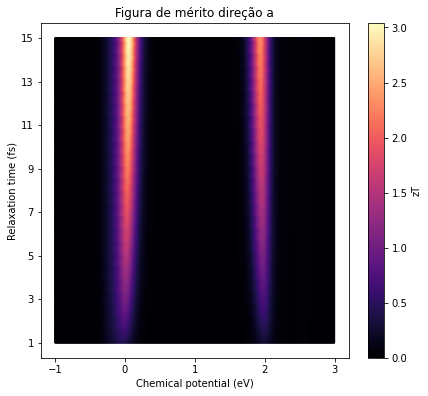

Criando figura...


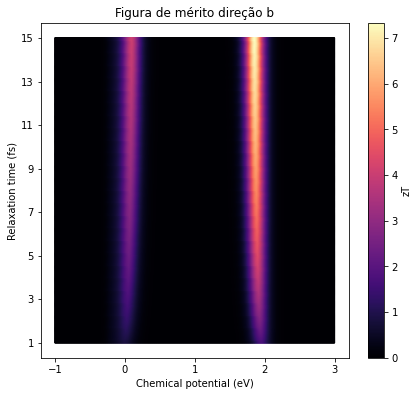

Criando figura...


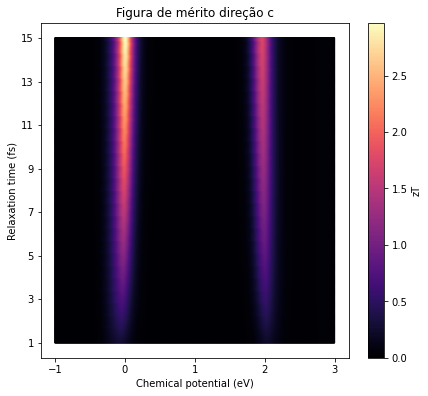

Done!


In [16]:
import matplotlib.pyplot as plt
   

def plot_ZT(direcao_data, direcao_name,  X = x, Y = y):
    """A direção deve ser a, b ou c"""
    
    print('Criando figura...')
    fig = plt.figure(figsize=(6, 6))
    plt.subplots_adjust(top=0.9, bottom=0.125, left=0.11, right=1.0, hspace=0.2, wspace=0.2)
    plt.scatter(X, Y, c=direcao_data, cmap='magma', vmin=0, s=0.1)
    plt.ylabel("Relaxation time (fs)")
    plt.xlabel("Chemical potential (eV)")
    plt.yticks([1,3,5,7,9,11,13,15])
    plt.xticks([-1,0,1,2,3])
    plt.colorbar(label='zT')
    plt.title("Figura de mérito direção"+" "+direcao_name)
    plt.show()
#    print(f'Salvando figura...')
#    plt.savefig(fname='direcao_c.png', format='png', dpi=150)


arquivo = open('./ZT_calculado', 'r')
x = []
y = []
a = []
b = []
c = []
print(f'Carregando dados...')
for coluna in arquivo:
    coluna = [float(i) for i in coluna.strip().split()]
    if coluna[0] <= 15 and coluna[1] >= -1:
        x.append(coluna[1])
        y.append(coluna[0])
        a.append(coluna[3])
        b.append(coluna[4])
        c.append(coluna[5])


plot_ZT(a, "a")
plot_ZT(b, "b")
plot_ZT(c, "c")
        
print(f'Done!')
